## 项目内容：构建神经网络，预测共享单车使用人数
环境：Python 3.6

In [53]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 加载和准备数据
数据集特征：
Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv
	
	- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [54]:
data_path = 'Bike-Sharing-Dataset/hour.csv'
rides = pd.read_csv(data_path)

In [55]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### 数据集可视化
此处使用的是hour.csv数据，将cnt列（骑车用户数汇总列）按照日期分布进行绘图；

下图展示的是数据集中前十天左右的汽车人数（不是精确的十天，因为观察数据集发现，某些天不一定是24个条目）: 可以看出某些特征与骑车用户数之间关系，如周末骑车人数少些，工作日上下班期间是骑行高峰期。同时，温度、湿度和风速信息，都会影响骑行人数。

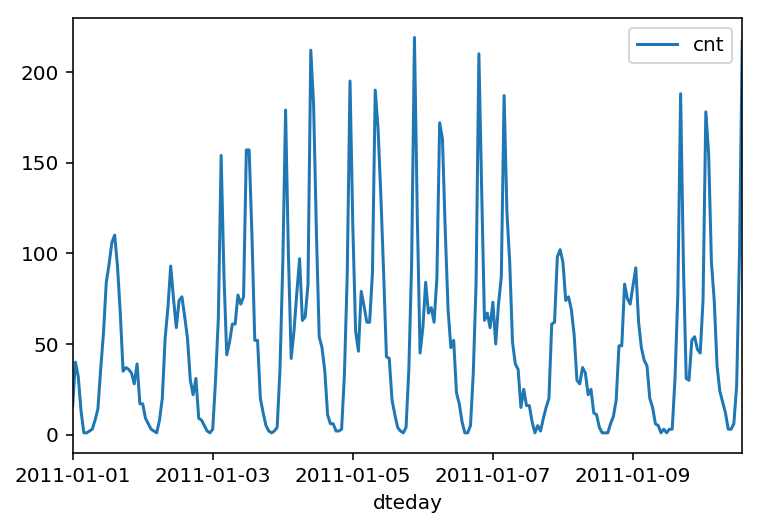

In [56]:
rides[:24*10].plot(x='dteday', y='cnt')

### 分类特征的哑编码
分类变量：例如季节、天气、月份、hour、weekday，对这些分类变量创建二进制虚拟变量

数据集中存在明显相关性的特征：如weekday与workingday，atemp与temp，在这里只取其一以简化模型

In [57]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### 连续数值变量的标准化
均值：0，标准差为：1

同时保存换算因子，以便使用网络进行预测时可以还原数据

In [58]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [59]:
target_fields = ['cnt', 'casual', 'registered']

X = data.drop(target_fields, axis=1)
y = data[target_fields]

### 将数据集拆分为训练、测试、验证数据集
保留数据的10%作为测试数据集，用于训练完网络之后的模型评估。使用该数据集进行预测，与实际的骑行人数对比，计算MAE。

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
print("train set: ", X_train.shape)
print("test set: ", X_test.shape)

train set:  (15641, 56)
test set:  (1738, 56)


### 模型初步尝试

In [61]:
from sklearn import metrics
from sklearn import preprocessing
#线性回归
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(X_train, y_train)
# print(clf.coef_)
y_pred = clf.predict(X_test)
print("model: LinearRegression, Test score: ", clf.score(X_test,y_test))
print("model: LinearRegression, MAE: ", metrics.mean_absolute_error(y_test, y_pred))

model: LinearRegression, Test score:  0.645101812875
model: LinearRegression, MAE:  0.422185110781


In [62]:
# 神经网络, 利用sklearn中的MLPRegressor多层感知器实现, 
# 为三层神经网络，每层都是全连接层，relu激活，隐藏层节点数选择（56+3）／2，经验参数是在输入节点数到输出节点数之间
from sklearn.neural_network import MLPRegressor
import numpy as np
MLPmodel = MLPRegressor(hidden_layer_sizes=(30,), learning_rate='adaptive',max_iter=20000).fit(X_train, y_train)
y_MLPmodel_pred = MLPmodel.predict(X_test)

print("model: MLPRegressor, Test score: ", MLPmodel.score(X_test,y_test))
print("model: MLPRegressor, MAE: ", metrics.mean_absolute_error(y_test, y_MLPmodel_pred))

model: MLPRegressor, Test score:  0.925277914988
model: MLPRegressor, MAE:  0.17209156244


In [63]:
# SVM模型
# 这里只将cnt作为输出
from sklearn import svm

smodel = svm.SVR(kernel='rbf', C=100)
y_cnt = y_train.drop(['casual', 'registered'], axis=1)
y_cnt_test = y_test.drop(['casual', 'registered'], axis=1)

smodel.fit(X_train, y_cnt.values.flatten())
y_smodel_pred = smodel.predict(X_test)

print("model: SVR, Test score: ", smodel.score(X_test,y_cnt_test.values.flatten()))
print("model: SVR, MAE: ", metrics.mean_absolute_error(y_cnt_test.values.flatten(), y_smodel_pred))

model: SVR, Test score:  0.936447354465
model: SVR, MAE:  0.165413963156


In [64]:
# 决策树模型
from sklearn.tree import DecisionTreeRegressor
dmodel=DecisionTreeRegressor(min_samples_split=20)
dmodel.fit(X_train, y_train)

y_dmodel_pred=dmodel.predict(X_test)
# print(y_dmodel_pred)
print("Model: DecisionTreeRegressor, Test score: ", dmodel.score(X_test,y_test))
print("Model: DecisionTreeRegressor, MAE: ", metrics.mean_absolute_error(y_test, y_dmodel_pred))

Model: DecisionTreeRegressor, Test score:  0.845002102861
Model: DecisionTreeRegressor, MAE:  0.223231891139


### 构建模型

In [ ]:
import numpy as np
from sklearn import svm
from sklearn import metrics
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble.forest import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

In [66]:
def predict_evaluate(est, X_train, y_train, X_test, y_test):
    """ train/fit model on train set, predict test set, then calculate MSE
        Parameters
        ----------
        est: sklearn estimator / regressor
        X_train, y_train, X_test, y_test: train set and test set
        
        Returns
        -------
        y_pred: prediction of test set
        mae: MAE of y_pred vs. y_test
    """
    est.fit(X_train, y_train)
    y_pred = est.predict(X_test)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    return y_pred, mae

In [68]:
def run_test():
    for i, est in enumerate((
    DecisionTreeRegressor(min_samples_split=20),
    ExtraTreesRegressor(n_estimators=100, max_depth=None, min_samples_split=1.0, random_state=0),
    RandomForestRegressor(n_estimators=1000, max_depth=15, random_state=0, min_samples_split=3, n_jobs=-1),
    GradientBoostingRegressor(n_estimators=150, max_depth=10, random_state=0, min_samples_leaf=20, learning_rate=0.1, subsample=0.7, loss='ls'),
    svm.SVR(C=30),
    MLPRegressor(learning_rate='adaptive',max_iter=20000).fit(X_train, y_train)
    )):
        y_cnt = y_train.drop(['casual', 'registered'], axis=1)
        y_cnt_test = y_test.drop(['casual', 'registered'], axis=1)

        est_name = str(est).split('(')[0]
        if est_name == 'SVR' or est_name == 'GradientBoostingRegressor':
            y_pred, mae = predict_evaluate(est, X_train, y_cnt.values.flatten(), X_test, y_cnt_test.values.flatten())
        else:
            y_pred, mae = predict_evaluate(est, X_train, y_cnt.values.flatten(), X_test, y_cnt_test.values.flatten())

        print(est_name, np.round(mae, 4))

run_test()

DecisionTreeRegressor 0.2127
ExtraTreesRegressor 0.7165
RandomForestRegressor 0.2557
GradientBoostingRegressor 0.1724
SVR 0.1776
MLPRegressor 0.1527


### Grid Search网格搜索调节模型组合参数
网格搜索最优化参数，然后最优化参数的模型对test set预测，结果保存在outfn文件路径中

In [145]:
def grid_search_est(X_train, y_train, X_test, y_test, est, param, outfn):
    """ hyperparameter tuning for models using GridSearchCV
        Parameters
        ----------
        est: sklearn estimator / regressor
        param: set of parameters to be tuned
        outfn: file name for storing predication made by the model with best tuned params
        
        Returns
        -------
        best_params_: best tuned params
    """
    est_name = str(est).split('(')[0]
    print('grid_search_est --', est_name)

    # this may take a while .....
    gs_cv = GridSearchCV(est, param, n_jobs=4, verbose=2)
    gs_cv.fit(X_train, y_train)
     
    result = gs_cv.predict(X_test)
    mae_test = metrics.mean_absolute_error(y_test, result)
    print('grid_search_est --', est_name, '-- best params: ', gs_cv.best_params_)
    print("Grid scores on development set:")
    for params, mean_score, scores in gs_cv.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() * 2, params))
    print('grid_search_est --', est_name, '-- mae on test set: ', mae_test)
    # 还原数据
    mean, std = scaled_features['cnt']
    
    print(result)
    if est_name == 'SVR' or est_name == 'GradientBoostingRegressor':
        result = result * std + mean
        target = y_cnt_test['cnt'].values * std + mean
    else:
        result = result[:, 0] * std + mean
        target = y_test[:]['cnt'] * std + mean
    

    dff = pd.DataFrame({'dteday': rides.ix[X_test.index]['dteday'], 'mnth': rides.ix[X_test.index]['mnth'], 
                        'hr': rides.ix[X_test.index]['hr'], 'cnt': target, 'prediction': result})
    dff.to_csv(outfn, index = False, columns=['dteday', 'mnth', 'hr', 'cnt', 'prediction'])
    
    return gs_cv.best_params_

### RandomForestRegressor网格搜索调参： 
调节随机森林中决策树个数，决策树最大深度，切分的最少样本数（两个提前终止条件，相当于预剪枝）

In [132]:
param = {'n_estimators': [10, 20, 50],
         'max_depth': [5, 10, 15],
         'min_samples_split': [3, 5, 10],
         }
est = RandomForestRegressor(n_jobs=-1)
grid_search_est(X_train, y_train, X_test, y_test, est=est, param=param, outfn='./output/prediction_gs_rfr.csv')

grid_search_est -- RandomForestRegressor
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] max_depth=5, min_samples_split=3, n_estimators=10 ...............
[CV] max_depth=5, min_samples_split=3, n_estimators=10 ...............
[CV] max_depth=5, min_samples_split=3, n_estimators=10 ...............
[CV] max_depth=5, min_samples_split=3, n_estimators=20 ...............
[CV] ...... max_depth=5, min_samples_split=3, n_estimators=10 -   0.5s
[CV] max_depth=5, min_samples_split=3, n_estimators=20 ...............
[CV] ...... max_depth=5, min_samples_split=3, n_estimators=10 -   0.5s
[CV] ...... max_depth=5, min_samples_split=3, n_estimators=10 -   0.6s
[CV] max_depth=5, min_samples_split=3, n_estimators=20 ...............
[CV] max_depth=5, min_samples_split=3, n_estimators=50 ...............
[CV] ...... max_depth=5, min_samples_split=3, n_estimators=20 -   0.6s
[CV] max_depth=5, min_samples_split=3, n_estimators=50 ...............
[CV] ...... max_depth=5, min_samples_split=3, 

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.8s


[CV] ..... max_depth=10, min_samples_split=5, n_estimators=10 -   0.9s
[CV] max_depth=10, min_samples_split=5, n_estimators=10 ..............
[CV] ..... max_depth=10, min_samples_split=5, n_estimators=10 -   0.6s
[CV] max_depth=10, min_samples_split=5, n_estimators=10 ..............
[CV] ..... max_depth=10, min_samples_split=3, n_estimators=50 -   3.0s
[CV] max_depth=10, min_samples_split=5, n_estimators=20 ..............
[CV] ..... max_depth=10, min_samples_split=5, n_estimators=10 -   1.2s
[CV] max_depth=10, min_samples_split=5, n_estimators=20 ..............
[CV] ..... max_depth=10, min_samples_split=3, n_estimators=50 -   3.3s
[CV] max_depth=10, min_samples_split=5, n_estimators=20 ..............
[CV] ..... max_depth=10, min_samples_split=3, n_estimators=50 -   3.3s
[CV] max_depth=10, min_samples_split=5, n_estimators=50 ..............
[CV] ..... max_depth=10, min_samples_split=5, n_estimators=20 -   1.2s
[CV] max_depth=10, min_samples_split=5, n_estimators=50 ..............
[CV] .

[Parallel(n_jobs=4)]: Done  81 out of  81 | elapsed:   40.5s finished


grid_search_est -- RandomForestRegressor -- best params:  {'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 50}
Grid scores on development set:
0.494 (+/-0.019) for {'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 10}
0.498 (+/-0.016) for {'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 20}
0.498 (+/-0.017) for {'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 50}
0.490 (+/-0.021) for {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 10}
0.498 (+/-0.021) for {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 20}
0.500 (+/-0.019) for {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 50}
0.497 (+/-0.020) for {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 10}
0.494 (+/-0.020) for {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 20}
0.497 (+/-0.018) for {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50}
0.719 (+/-0.028) for {'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 10}
0.725 (+/-0.017) for {'m

{'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 50}

### MLPRegressor网格搜索调参：
主要调节神经网络迭代次数max_iter, 隐藏节点个数hidden_layer_sizes, L2 正则化项参数alpha，

In [133]:
param = {'max_iter': [5000, 10000, 12000, 15000, 17000, 20000, 250000],
         'hidden_layer_sizes':[(15,), (20,), (25,), (30,), (35,), (40,)],
         'alpha': [0.00001, 0.0001, 0.001]
         }
est = MLPRegressor(learning_rate='adaptive')
grid_search_est(X_train, y_train, X_test, y_test, est=est, param=param, outfn='./output/prediction_gs_mlp.csv')

grid_search_est -- MLPRegressor
Fitting 3 folds for each of 126 candidates, totalling 378 fits
[CV] alpha=1e-05, hidden_layer_sizes=(15,), max_iter=5000 ............
[CV] alpha=1e-05, hidden_layer_sizes=(15,), max_iter=5000 ............
[CV] alpha=1e-05, hidden_layer_sizes=(15,), max_iter=5000 ............
[CV] alpha=1e-05, hidden_layer_sizes=(15,), max_iter=10000 ...........
[CV] ... alpha=1e-05, hidden_layer_sizes=(15,), max_iter=5000 -   5.8s
[CV] alpha=1e-05, hidden_layer_sizes=(15,), max_iter=10000 ...........
[CV] ... alpha=1e-05, hidden_layer_sizes=(15,), max_iter=5000 -   5.9s
[CV] .. alpha=1e-05, hidden_layer_sizes=(15,), max_iter=10000 -   5.9s
[CV] alpha=1e-05, hidden_layer_sizes=(15,), max_iter=10000 ...........
[CV] alpha=1e-05, hidden_layer_sizes=(15,), max_iter=12000 ...........
[CV] ... alpha=1e-05, hidden_layer_sizes=(15,), max_iter=5000 -   6.2s
[CV] alpha=1e-05, hidden_layer_sizes=(15,), max_iter=12000 ...........
[CV] .. alpha=1e-05, hidden_layer_sizes=(15,), max_it

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   54.9s


[CV] .. alpha=1e-05, hidden_layer_sizes=(20,), max_iter=17000 -   5.3s
[CV] alpha=1e-05, hidden_layer_sizes=(20,), max_iter=20000 ...........
[CV] .. alpha=1e-05, hidden_layer_sizes=(20,), max_iter=17000 -   5.6s
[CV] alpha=1e-05, hidden_layer_sizes=(20,), max_iter=20000 ...........
[CV] .. alpha=1e-05, hidden_layer_sizes=(20,), max_iter=17000 -   5.6s
[CV] alpha=1e-05, hidden_layer_sizes=(20,), max_iter=250000 ..........
[CV] .. alpha=1e-05, hidden_layer_sizes=(20,), max_iter=20000 -   5.3s
[CV] alpha=1e-05, hidden_layer_sizes=(20,), max_iter=250000 ..........
[CV] .. alpha=1e-05, hidden_layer_sizes=(20,), max_iter=20000 -   5.4s
[CV] alpha=1e-05, hidden_layer_sizes=(20,), max_iter=250000 ..........
[CV] .. alpha=1e-05, hidden_layer_sizes=(20,), max_iter=20000 -   5.0s
[CV] alpha=1e-05, hidden_layer_sizes=(25,), max_iter=5000 ............
[CV] . alpha=1e-05, hidden_layer_sizes=(20,), max_iter=250000 -   6.0s
[CV] alpha=1e-05, hidden_layer_sizes=(25,), max_iter=5000 ............
[CV] .

[CV] .. alpha=1e-05, hidden_layer_sizes=(35,), max_iter=12000 -   8.1s
[CV] alpha=1e-05, hidden_layer_sizes=(35,), max_iter=15000 ...........
[CV] .. alpha=1e-05, hidden_layer_sizes=(35,), max_iter=15000 -   6.3s
[CV] alpha=1e-05, hidden_layer_sizes=(35,), max_iter=17000 ...........
[CV] .. alpha=1e-05, hidden_layer_sizes=(35,), max_iter=12000 -   8.3s
[CV] alpha=1e-05, hidden_layer_sizes=(35,), max_iter=17000 ...........
[CV] .. alpha=1e-05, hidden_layer_sizes=(35,), max_iter=15000 -   7.6s
[CV] alpha=1e-05, hidden_layer_sizes=(35,), max_iter=17000 ...........
[CV] .. alpha=1e-05, hidden_layer_sizes=(35,), max_iter=15000 -   7.3s
[CV] alpha=1e-05, hidden_layer_sizes=(35,), max_iter=20000 ...........
[CV] .. alpha=1e-05, hidden_layer_sizes=(35,), max_iter=17000 -   7.0s
[CV] alpha=1e-05, hidden_layer_sizes=(35,), max_iter=20000 ...........
[CV] .. alpha=1e-05, hidden_layer_sizes=(35,), max_iter=17000 -  11.2s
[CV] alpha=1e-05, hidden_layer_sizes=(35,), max_iter=20000 ...........
[CV] .

[CV] .. alpha=0.0001, hidden_layer_sizes=(20,), max_iter=5000 -   5.2s
[CV] alpha=0.0001, hidden_layer_sizes=(20,), max_iter=12000 ..........
[CV] .. alpha=0.0001, hidden_layer_sizes=(20,), max_iter=5000 -   4.5s
[CV] alpha=0.0001, hidden_layer_sizes=(20,), max_iter=12000 ..........
[CV] . alpha=0.0001, hidden_layer_sizes=(20,), max_iter=10000 -   5.6s
[CV] alpha=0.0001, hidden_layer_sizes=(20,), max_iter=12000 ..........
[CV] . alpha=0.0001, hidden_layer_sizes=(20,), max_iter=10000 -   5.3s
[CV] alpha=0.0001, hidden_layer_sizes=(20,), max_iter=15000 ..........
[CV] . alpha=0.0001, hidden_layer_sizes=(20,), max_iter=12000 -   5.2s
[CV] alpha=0.0001, hidden_layer_sizes=(20,), max_iter=15000 ..........


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  4.4min


[CV] . alpha=0.0001, hidden_layer_sizes=(20,), max_iter=12000 -   5.4s
[CV] alpha=0.0001, hidden_layer_sizes=(20,), max_iter=15000 ..........
[CV] . alpha=0.0001, hidden_layer_sizes=(20,), max_iter=12000 -   4.7s
[CV] alpha=0.0001, hidden_layer_sizes=(20,), max_iter=17000 ..........
[CV] . alpha=0.0001, hidden_layer_sizes=(20,), max_iter=15000 -   5.0s
[CV] alpha=0.0001, hidden_layer_sizes=(20,), max_iter=17000 ..........
[CV] . alpha=0.0001, hidden_layer_sizes=(20,), max_iter=15000 -   5.6s
[CV] alpha=0.0001, hidden_layer_sizes=(20,), max_iter=17000 ..........
[CV] . alpha=0.0001, hidden_layer_sizes=(20,), max_iter=15000 -   5.3s
[CV] alpha=0.0001, hidden_layer_sizes=(20,), max_iter=20000 ..........
[CV] . alpha=0.0001, hidden_layer_sizes=(20,), max_iter=17000 -   6.0s
[CV] alpha=0.0001, hidden_layer_sizes=(20,), max_iter=20000 ..........
[CV] . alpha=0.0001, hidden_layer_sizes=(20,), max_iter=17000 -   5.2s
[CV] alpha=0.0001, hidden_layer_sizes=(20,), max_iter=20000 ..........
[CV] .

[CV] .. alpha=0.0001, hidden_layer_sizes=(35,), max_iter=5000 -   4.5s
[CV] alpha=0.0001, hidden_layer_sizes=(35,), max_iter=12000 ..........
[CV] . alpha=0.0001, hidden_layer_sizes=(35,), max_iter=10000 -   5.0s
[CV] alpha=0.0001, hidden_layer_sizes=(35,), max_iter=12000 ..........
[CV] . alpha=0.0001, hidden_layer_sizes=(35,), max_iter=10000 -   5.4s
[CV] alpha=0.0001, hidden_layer_sizes=(35,), max_iter=12000 ..........
[CV] . alpha=0.0001, hidden_layer_sizes=(35,), max_iter=10000 -   4.2s
[CV] alpha=0.0001, hidden_layer_sizes=(35,), max_iter=15000 ..........
[CV] . alpha=0.0001, hidden_layer_sizes=(35,), max_iter=12000 -   4.2s
[CV] alpha=0.0001, hidden_layer_sizes=(35,), max_iter=15000 ..........
[CV] . alpha=0.0001, hidden_layer_sizes=(35,), max_iter=12000 -   4.9s
[CV] alpha=0.0001, hidden_layer_sizes=(35,), max_iter=15000 ..........
[CV] . alpha=0.0001, hidden_layer_sizes=(35,), max_iter=15000 -   4.4s
[CV] alpha=0.0001, hidden_layer_sizes=(35,), max_iter=17000 ..........
[CV] .

[CV] . alpha=0.001, hidden_layer_sizes=(15,), max_iter=250000 -   5.2s
[CV] alpha=0.001, hidden_layer_sizes=(20,), max_iter=5000 ............
[CV] . alpha=0.001, hidden_layer_sizes=(15,), max_iter=250000 -   4.2s
[CV] alpha=0.001, hidden_layer_sizes=(20,), max_iter=5000 ............
[CV] . alpha=0.001, hidden_layer_sizes=(15,), max_iter=250000 -   6.3s
[CV] alpha=0.001, hidden_layer_sizes=(20,), max_iter=10000 ...........
[CV] ... alpha=0.001, hidden_layer_sizes=(20,), max_iter=5000 -   5.6s
[CV] alpha=0.001, hidden_layer_sizes=(20,), max_iter=10000 ...........
[CV] ... alpha=0.001, hidden_layer_sizes=(20,), max_iter=5000 -   5.7s
[CV] alpha=0.001, hidden_layer_sizes=(20,), max_iter=10000 ...........
[CV] ... alpha=0.001, hidden_layer_sizes=(20,), max_iter=5000 -   4.9s
[CV] alpha=0.001, hidden_layer_sizes=(20,), max_iter=12000 ...........
[CV] .. alpha=0.001, hidden_layer_sizes=(20,), max_iter=10000 -   5.8s
[CV] alpha=0.001, hidden_layer_sizes=(20,), max_iter=12000 ...........
[CV] .

[CV] .. alpha=0.001, hidden_layer_sizes=(30,), max_iter=17000 -   4.0s
[CV] alpha=0.001, hidden_layer_sizes=(30,), max_iter=20000 ...........
[CV] .. alpha=0.001, hidden_layer_sizes=(30,), max_iter=17000 -   6.1s
[CV] alpha=0.001, hidden_layer_sizes=(30,), max_iter=250000 ..........
[CV] .. alpha=0.001, hidden_layer_sizes=(30,), max_iter=20000 -   5.1s
[CV] alpha=0.001, hidden_layer_sizes=(30,), max_iter=250000 ..........
[CV] .. alpha=0.001, hidden_layer_sizes=(30,), max_iter=20000 -   6.1s
[CV] alpha=0.001, hidden_layer_sizes=(30,), max_iter=250000 ..........
[CV] .. alpha=0.001, hidden_layer_sizes=(30,), max_iter=20000 -   4.0s
[CV] alpha=0.001, hidden_layer_sizes=(35,), max_iter=5000 ............
[CV] . alpha=0.001, hidden_layer_sizes=(30,), max_iter=250000 -   4.4s
[CV] alpha=0.001, hidden_layer_sizes=(35,), max_iter=5000 ............
[CV] . alpha=0.001, hidden_layer_sizes=(30,), max_iter=250000 -   5.4s
[CV] alpha=0.001, hidden_layer_sizes=(35,), max_iter=5000 ............
[CV] .

[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  8.8min


[CV] ... alpha=0.001, hidden_layer_sizes=(40,), max_iter=5000 -   4.7s
[CV] alpha=0.001, hidden_layer_sizes=(40,), max_iter=10000 ...........
[CV] ... alpha=0.001, hidden_layer_sizes=(40,), max_iter=5000 -   5.6s
[CV] alpha=0.001, hidden_layer_sizes=(40,), max_iter=10000 ...........
[CV] .. alpha=0.001, hidden_layer_sizes=(40,), max_iter=10000 -   6.0s
[CV] ... alpha=0.001, hidden_layer_sizes=(40,), max_iter=5000 -   6.1s
[CV] alpha=0.001, hidden_layer_sizes=(40,), max_iter=12000 ...........
[CV] alpha=0.001, hidden_layer_sizes=(40,), max_iter=12000 ...........
[CV] .. alpha=0.001, hidden_layer_sizes=(40,), max_iter=10000 -   5.0s
[CV] alpha=0.001, hidden_layer_sizes=(40,), max_iter=12000 ...........
[CV] .. alpha=0.001, hidden_layer_sizes=(40,), max_iter=10000 -   4.9s
[CV] alpha=0.001, hidden_layer_sizes=(40,), max_iter=15000 ...........
[CV] .. alpha=0.001, hidden_layer_sizes=(40,), max_iter=12000 -   4.5s
[CV] alpha=0.001, hidden_layer_sizes=(40,), max_iter=15000 ...........
[CV] .

[Parallel(n_jobs=4)]: Done 378 out of 378 | elapsed:  9.3min finished


grid_search_est -- MLPRegressor -- best params:  {'alpha': 0.001, 'hidden_layer_sizes': (40,), 'max_iter': 12000}
Grid scores on development set:
0.914 (+/-0.007) for {'alpha': 1e-05, 'hidden_layer_sizes': (15,), 'max_iter': 5000}
0.916 (+/-0.008) for {'alpha': 1e-05, 'hidden_layer_sizes': (15,), 'max_iter': 10000}
0.913 (+/-0.007) for {'alpha': 1e-05, 'hidden_layer_sizes': (15,), 'max_iter': 12000}
0.915 (+/-0.005) for {'alpha': 1e-05, 'hidden_layer_sizes': (15,), 'max_iter': 15000}
0.914 (+/-0.008) for {'alpha': 1e-05, 'hidden_layer_sizes': (15,), 'max_iter': 17000}
0.912 (+/-0.007) for {'alpha': 1e-05, 'hidden_layer_sizes': (15,), 'max_iter': 20000}
0.912 (+/-0.008) for {'alpha': 1e-05, 'hidden_layer_sizes': (15,), 'max_iter': 250000}
0.916 (+/-0.008) for {'alpha': 1e-05, 'hidden_layer_sizes': (20,), 'max_iter': 5000}
0.918 (+/-0.005) for {'alpha': 1e-05, 'hidden_layer_sizes': (20,), 'max_iter': 10000}
0.916 (+/-0.007) for {'alpha': 1e-05, 'hidden_layer_sizes': (20,), 'max_iter': 12

{'alpha': 0.001, 'hidden_layer_sizes': (40,), 'max_iter': 12000}

### SVR网格搜索调参: 
主要调节误差项惩罚参数C（即正则化程度）

In [146]:
param = {'C': [1, 10, 20, 30, 40],
         }
est = svm.SVR()
grid_search_est(X_train, y_cnt.values.flatten(), X_test, y_cnt_test.values.flatten(), est=est, param=param, outfn='./output/prediction_gs_svr.csv')

grid_search_est -- SVR
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] C=1 .............................................................
[CV] C=1 .............................................................
[CV] C=1 .............................................................
[CV] C=10 ............................................................
[CV] .................................................... C=1 -  18.6s
[CV] C=10 ............................................................
[CV] .................................................... C=1 -  18.6s
[CV] C=10 ............................................................
[CV] .................................................... C=1 -  18.7s
[CV] C=20 ............................................................
[CV] ................................................... C=10 -  23.9s
[CV] C=20 ............................................................
[CV] ................................................... C=10 -  

[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  2.1min finished


grid_search_est -- SVR -- best params:  {'C': 40}
Grid scores on development set:
0.753 (+/-0.006) for {'C': 1}
0.881 (+/-0.003) for {'C': 10}
0.907 (+/-0.002) for {'C': 20}
0.916 (+/-0.003) for {'C': 30}
0.921 (+/-0.004) for {'C': 40}
grid_search_est -- SVR -- mae on test set:  0.173669287681
[-0.97803725 -1.0683417   1.51382467 ...,  2.56870426 -1.07102134
 -0.99507199]


{'C': 40}

### GradientBoostingRegressor网格搜索调参：
主要调节学习率，单个regression estimators最大深度，切分的最少样本数（两个提前终止条件，相当于预剪枝）

In [150]:
param = {'learning_rate': [0.1, 0.05],
         'max_depth': [5, 10, 15],
         'min_samples_leaf': [5, 10, 20],
         }
est = GradientBoostingRegressor(n_estimators=150)
grid_search_est(X_train, y_cnt.values.flatten(), X_test, y_cnt_test.values.flatten(), est=est, param=param, outfn='./output/prediction_gs_gbr.csv')

grid_search_est -- GradientBoostingRegressor
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] learning_rate=0.1, max_depth=5, min_samples_leaf=5 ..............
[CV] learning_rate=0.1, max_depth=5, min_samples_leaf=5 ..............
[CV] learning_rate=0.1, max_depth=5, min_samples_leaf=5 ..............
[CV] learning_rate=0.1, max_depth=5, min_samples_leaf=10 .............
[CV] .... learning_rate=0.1, max_depth=5, min_samples_leaf=10 -   8.7s
[CV] learning_rate=0.1, max_depth=5, min_samples_leaf=10 .............
[CV] ..... learning_rate=0.1, max_depth=5, min_samples_leaf=5 -   8.9s
[CV] ..... learning_rate=0.1, max_depth=5, min_samples_leaf=5 -   9.0s
[CV] learning_rate=0.1, max_depth=5, min_samples_leaf=10 .............
[CV] learning_rate=0.1, max_depth=5, min_samples_leaf=20 .............
[CV] ..... learning_rate=0.1, max_depth=5, min_samples_leaf=5 -   9.1s
[CV] learning_rate=0.1, max_depth=5, min_samples_leaf=20 .............
[CV] .... learning_rate=0.1, max_depth=5, 

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.9min


[CV] ... learning_rate=0.05, max_depth=5, min_samples_leaf=20 -   9.9s
[CV] learning_rate=0.05, max_depth=10, min_samples_leaf=5 ............
[CV] ... learning_rate=0.05, max_depth=5, min_samples_leaf=20 -   9.9s
[CV] learning_rate=0.05, max_depth=10, min_samples_leaf=5 ............
[CV] ... learning_rate=0.1, max_depth=15, min_samples_leaf=20 -  46.4s
[CV] learning_rate=0.05, max_depth=10, min_samples_leaf=10 ...........
[CV] ... learning_rate=0.05, max_depth=10, min_samples_leaf=5 -  40.4s
[CV] learning_rate=0.05, max_depth=10, min_samples_leaf=10 ...........
[CV] .. learning_rate=0.05, max_depth=10, min_samples_leaf=10 -  33.8s
[CV] learning_rate=0.05, max_depth=10, min_samples_leaf=10 ...........
[CV] ... learning_rate=0.05, max_depth=10, min_samples_leaf=5 -  38.7s
[CV] learning_rate=0.05, max_depth=10, min_samples_leaf=20 ...........
[CV] ... learning_rate=0.05, max_depth=10, min_samples_leaf=5 -  39.2s
[CV] learning_rate=0.05, max_depth=10, min_samples_leaf=20 ...........
[CV] .

[Parallel(n_jobs=4)]: Done  54 out of  54 | elapsed:  7.9min finished


grid_search_est -- GradientBoostingRegressor -- best params:  {'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 10}
Grid scores on development set:
0.889 (+/-0.002) for {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 5}
0.889 (+/-0.006) for {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 10}
0.882 (+/-0.003) for {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 20}
0.929 (+/-0.005) for {'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 5}
0.930 (+/-0.004) for {'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 10}
0.927 (+/-0.000) for {'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 20}
0.923 (+/-0.005) for {'learning_rate': 0.1, 'max_depth': 15, 'min_samples_leaf': 5}
0.928 (+/-0.001) for {'learning_rate': 0.1, 'max_depth': 15, 'min_samples_leaf': 10}
0.929 (+/-0.003) for {'learning_rate': 0.1, 'max_depth': 15, 'min_samples_leaf': 20}
0.828 (+/-0.007) for {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 5}

{'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 10}

### 检查预测结果
使用测试数据检查网络对数据建模的效果

In [153]:
def plot_estimator(outfn):
    fig, ax = plt.subplots(figsize=(20, 4))
    # 读取已保存的模型训练结果
    results = pd.read_csv(outfn)
    predictions = results['prediction']
    targets = results['cnt']
    ax.plot(predictions, label='Prediction')
    ax.plot(targets, label='Data')
    ax.set_xlim(right=predictions.shape[0])
    ax.legend()

    dates = pd.to_datetime(rides.ix[X_test.index]['dteday'])
    dates = dates.apply(lambda d: d.strftime('%b %d'))
    ax.set_xticks(np.arange(len(dates))[12::24])
    _ = ax.set_xticklabels(dates[12::24], rotation=45)

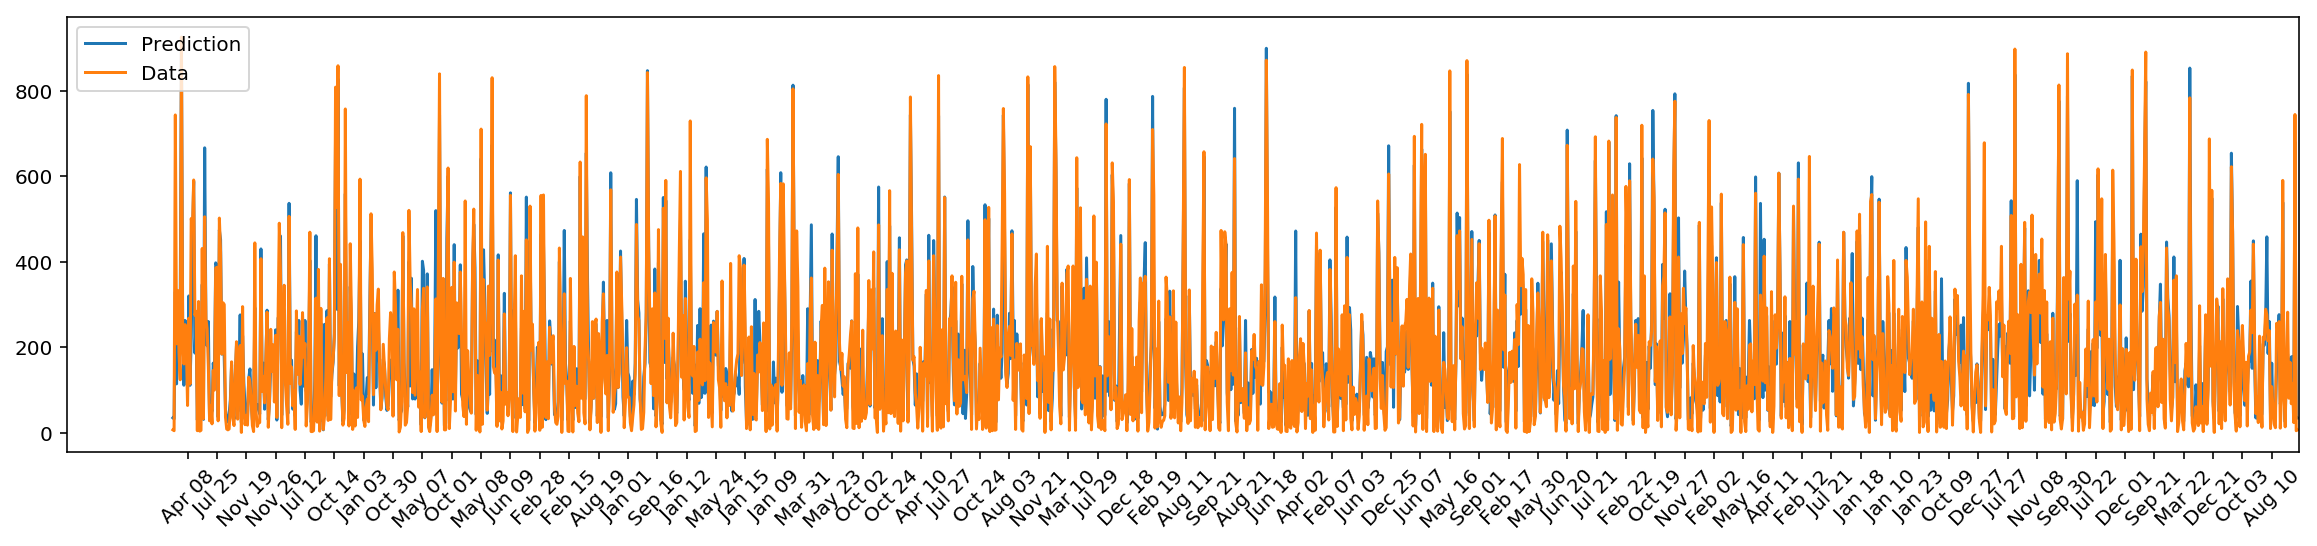

In [154]:
plot_estimator('./output/prediction_gs_rfr.csv')

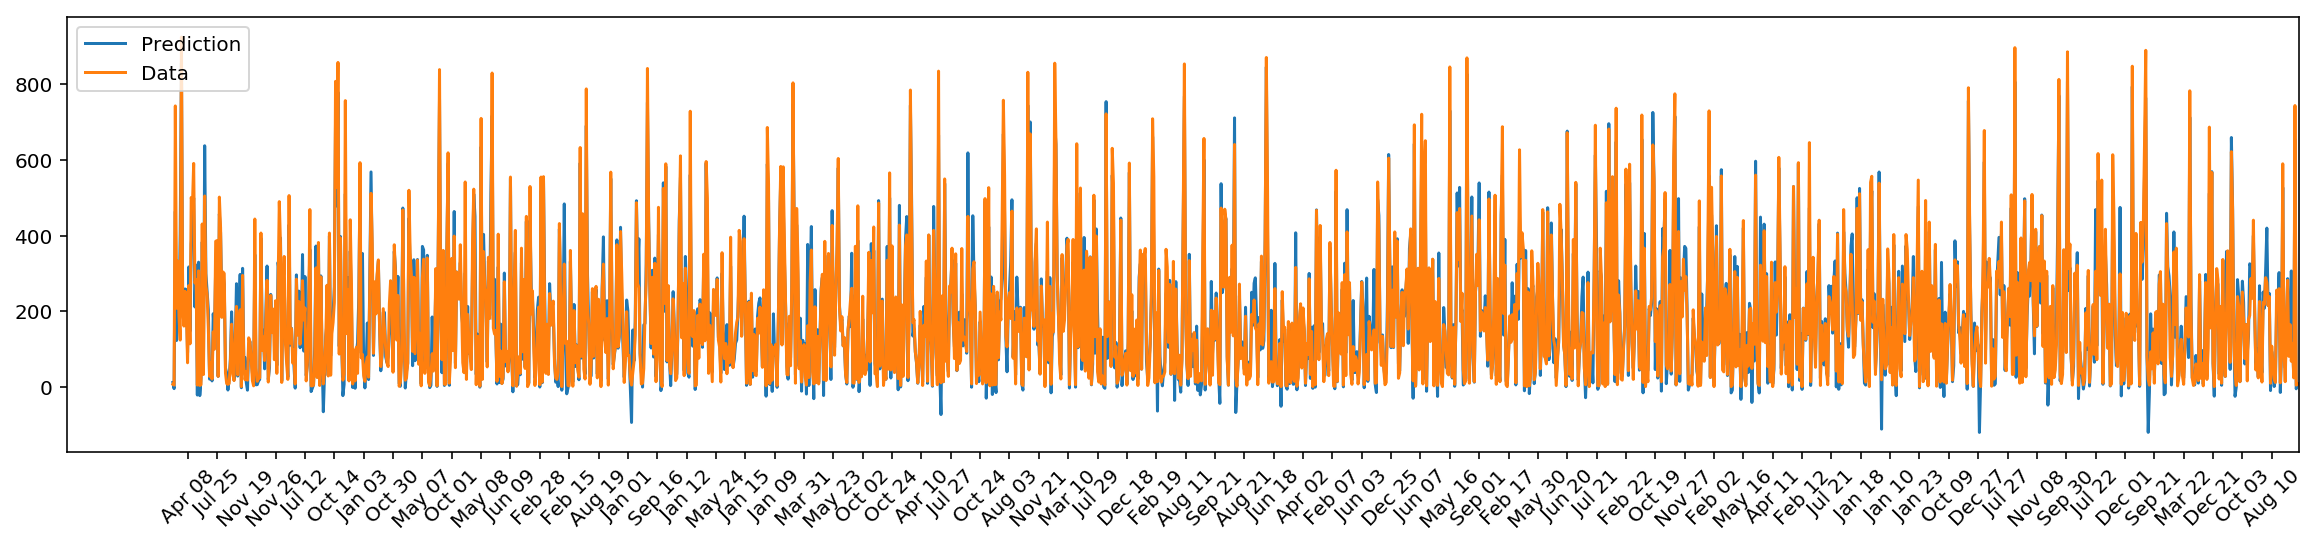

In [155]:
plot_estimator('./output/prediction_gs_svr.csv')

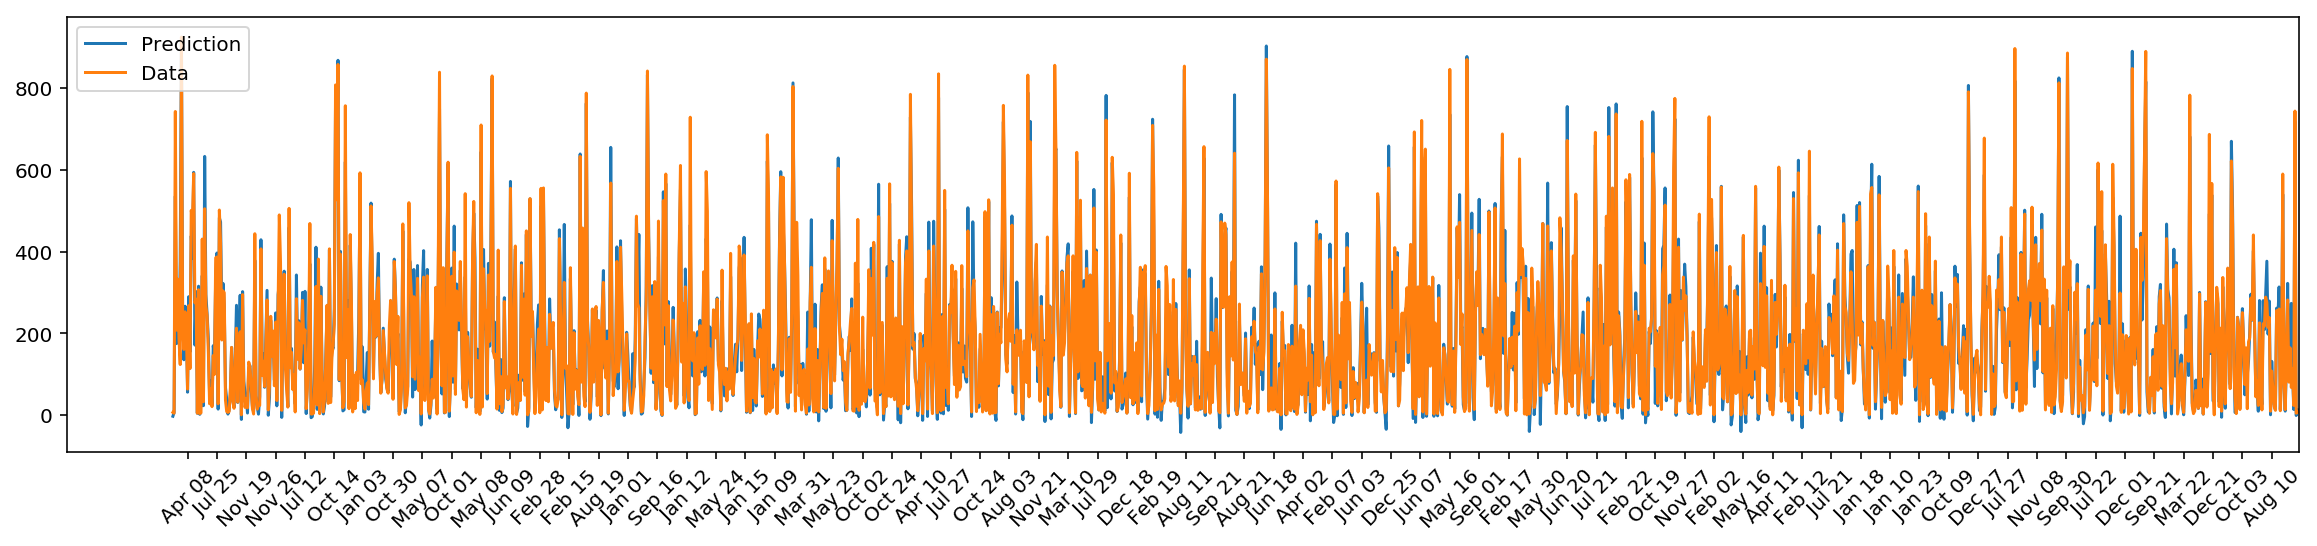

In [156]:
plot_estimator('./output/prediction_gs_mlp.csv')

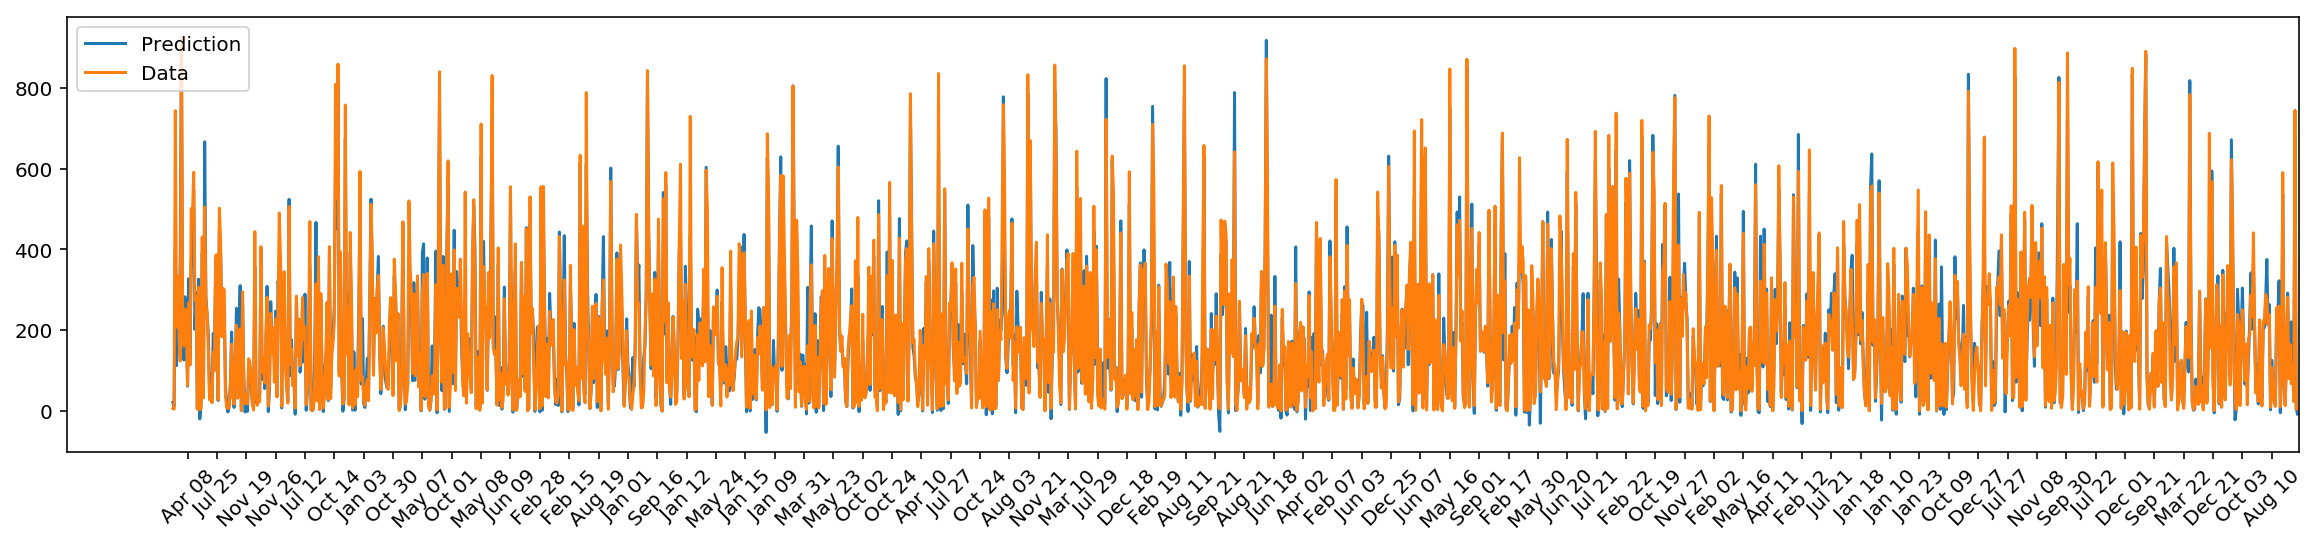

In [157]:
plot_estimator('./output/prediction_gs_gbr.csv')

### 模型组合ensemble
目前表现比较好的模型是

GradientBoostingRegressor， MAE：0.16

SVR， MAE：0.17

MLP， MAE：0.16

单个回归器的预测能力还比较弱，可以使用组合方法如blending，stacking方法，进行模型组合，增强模型的预测能力

这也是很多大数据比赛中，除神经网络以外表现非常好的一个方法